# Load Libraries

In [1]:
from __future__ import print_function
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import numpy as np
#Import our classes
from nets.unet import generate_batch_norm_unet
from utils.image import ImageDataGenerator
from utils.dice import dice_coef


#Import specific keras classes
from keras.optimizers import Adam
from keras.callbacks import  ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.utils import to_categorical


#Make sure we remove any randomness
from numpy.random import seed
seed(1)

try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

#UNCOMMENT BELOW TO DETERMINE GPU
# from keras import backend as K
# import tensorflow as tf
# import os
# #Use one GPU
# if K.backend() == 'tensorflow':
#     # Use only gpu #X (with tf.device(/gpu:X) does not work)
#     os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#     # Automatically choose an existing and supported device if the specified one does not exist
#     config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
#     # To constrain the use of gpu memory, otherwise all memory is used
#     config.gpu_options.allow_growth = True
#     sess = tf.Session(config=config)
#     K.set_session(sess)

/Users/base/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Display images and shapes for sanity check

(-0.5, 127.5, 127.5, -0.5)

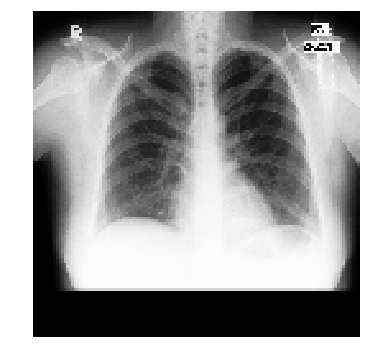

In [5]:
#Show an originalimage
image = cv2.imread('data/training/training_images/images/MCUCXR_0001_0.png',0)
plt.figure(figsize=(12,6))
plt.imshow(image, cmap=cm.Greys_r, interpolation='none')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

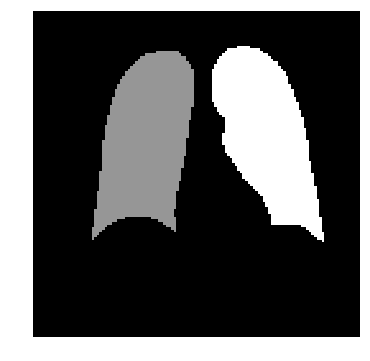

In [6]:
#Show corresponding mask
mask = cv2.imread('data/training/training_masks/images/MCUCXR_0001_0.png',0)
plt.figure(figsize=(12,6))
plt.imshow(mask, cmap=cm.Greys_r, interpolation='none')
plt.axis('off')

In [7]:
print ('Image shape: ',image.shape)
print ('Mask shape: ',mask.shape)

Image shape:  (128, 128)
Mask shape:  (128, 128)


# Targets in neural network are binary representation. So our masks.

Binary shape:  (128, 128, 3)


(-0.5, 127.5, 127.5, -0.5)

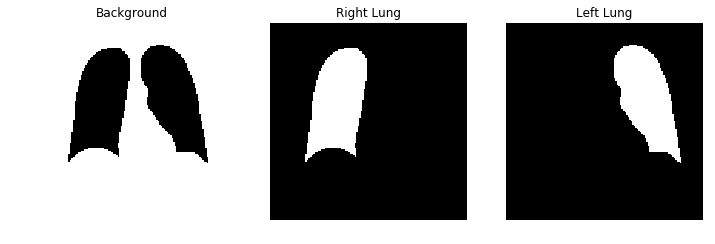

In [10]:
binary_mask = to_categorical(mask, num_classes=3)
print ('Binary shape: ',binary_mask.shape)

plt.figure(figsize=(12,6))
ax = plt.subplot(1, 3, 1)
ax.set_title('Background')
ax.imshow(binary_mask[...,0], cmap=cm.Greys_r, interpolation='none')
ax.axis('off')
ax = plt.subplot(1, 3, 2)
ax.set_title('Right Lung')
ax.imshow(binary_mask[...,1], cmap=cm.Greys_r, interpolation='none')
ax.axis('off')
ax = plt.subplot(1, 3, 3)
ax.set_title('Left Lung')
ax.imshow(binary_mask[...,2], cmap=cm.Greys_r, interpolation='none')
ax.axis('off')

In [11]:
binary_mask.shape

(128, 128, 3)

# Data Generators

## Data generators in Keras are iterators that perform slow loading of data. Imagine if you had to train a model on 1M images. You cannot preload them in one big numpy array. You need to load them in batches and then process them through your model

In [12]:

def custom_image_generator(generator, directory, seed=None, batch_size=16,  target_size=(128, 128), 
                           color_mode="grayscale", class_mode=None, isMask=False, num_classes=None):
    """
    Read images from a dirctory batch-size wise
    If images are masks (e.g. 128x128x1) then convert them to multi-label arrays (e.g. 128x128x3) so that they match the output of UNet 
    """
    import numpy as np
    
    #Read from directory (flow_from_directory)
    iterator = generator.flow_from_directory(directory=directory,
                                             target_size=target_size,
                                             color_mode=color_mode,
                                             class_mode=class_mode,
                                             batch_size=batch_size,
                                             seed=seed,
                                             shuffle=True)


    
    for batch_x in iterator:
        #if image is a mask convert to a multi-label array (binary matrix: 128x128x3)
        if isMask==True:
            batch_x=to_categorical(batch_x, num_classes)
        yield batch_x

In [14]:
#Random seed set into a fixed value to apply same augmentations to images and masks. Otherwise they would not be the same.
seed=1 

#Set the batch size
batch_size=4


#Create the image training generator
image_train_datagen = custom_image_generator(
            ImageDataGenerator(rotation_range=10.,  #Augmentation 1: Rotate images randomly within +- 20 degrees
                     width_shift_range=0.1, #Augmentation 2: Translate image left or right by 10% 
                     height_shift_range=0.1,  #Augmentation 3: Translate image up or down by 10% 
                     zoom_range=0.2, rescale=1./255.), #Augmentation 4: Zoom in/out 20% 
            directory='data/training/training_images/',  #Directory holding the raw images
            seed=seed, #Use a specific random seed
            target_size=(128,128), #Resize images if needed to fit into the Input layer of Unet
            color_mode='grayscale', #Load them as one-channel (i.e. grayscale)
            batch_size=batch_size, #Use batch size of 32
        )

#Create the mask training generator
mask_train_datagen = custom_image_generator(
            ImageDataGenerator(rotation_range=10.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2),
            directory='data/training/training_masks/',
            seed=seed,
            target_size=(128,128),
            color_mode='grayscale',
            batch_size=batch_size,
            isMask=True
)


#Create the image validation generator
image_val_datagen = custom_image_generator(
            ImageDataGenerator(rescale=1./255.),
            directory='data/validation/validation_images/',
            seed=seed,
            target_size=(128,128),
            color_mode='grayscale',
            batch_size=batch_size,
        )

#Create the mask validation generator
mask_val_datagen = custom_image_generator(
            ImageDataGenerator(),
            directory='data/validation/validation_masks/',
            seed=seed,
            target_size=(128,128),
            color_mode='grayscale',
            batch_size=batch_size,
            isMask=True
        )



# combine generators into one which yields image and images
train_generator = zip(image_train_datagen, mask_train_datagen)
val_generator = zip(image_val_datagen, mask_val_datagen)


# Create UNet Model 

In [15]:

#Generate UNet with base number of filters and number of labels for segmntation
model = generate_batch_norm_unet(base_num_filters=16, num_classes=3, kernel_size=(10,10))

print (model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 25616       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

# Callbacks (e.g. save logs, save best model)

In [16]:
#Save UNet model on smallest validation loss
model_checkpoint = ModelCheckpoint('unet_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reducer = ReduceLROnPlateau(monitor='loss', factor=.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

#Save logs to file
logger = CSVLogger('experiment.txt', separator=',', append=False)

#Put the 2 callbacks together
callbacks = [model_checkpoint,reducer, logger]


# Training / Validation 

In [17]:
# Goal: make the more frequent labels weigh less
class_frequencies = np.array([1221018,  221993,  195389])
class_weights = class_frequencies.sum() / class_frequencies.astype(np.float32)
class_weights = class_weights ** 0.5
print (class_weights)

train_steps_per_epoch = round(100/batch_size)
val_steps_per_epoch = round(38/batch_size)

def dice_error(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model.compile(optimizer=Adam(lr=1e-3), loss=[dice_error], metrics=[dice_coef], sample_weight_mode='temporal')
model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=150, validation_data=val_generator, validation_steps=val_steps_per_epoch, class_weight=class_weights, callbacks=callbacks, verbose=0)




[1.15837436 2.71669153 2.89574233]
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 38 images belonging to 1 classes.
Found 38 images belonging to 1 classes.

Epoch 00001: val_loss improved from inf to 0.22071, saving model to unet_model.h5

Epoch 00002: val_loss improved from 0.22071 to 0.07062, saving model to unet_model.h5


KeyboardInterrupt: 

# Evaluate Model

In [18]:
[val_loss, dice_coefficient]=model.evaluate_generator(val_generator,steps=38/batch_size)
print ('Validation loss: ',val_loss, ' Dice coefficient: ',dice_coefficient)

Validation loss:  0.058944639406706155  Dice coefficient:  0.9410553292224282


# Visualization

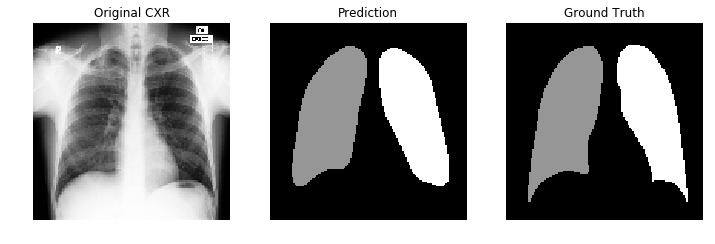

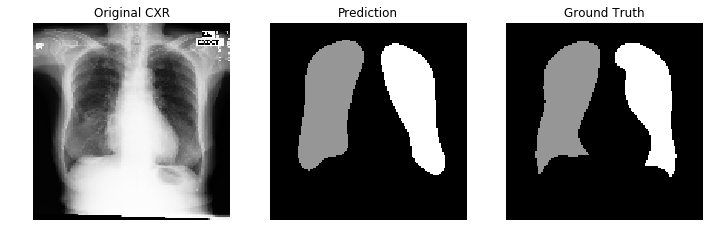

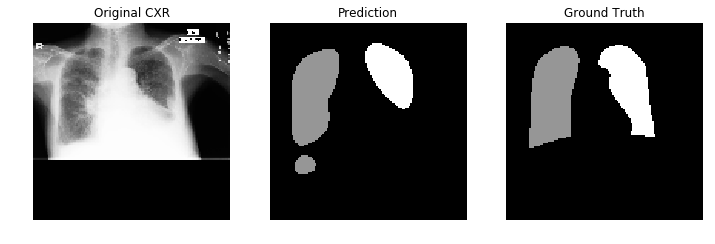

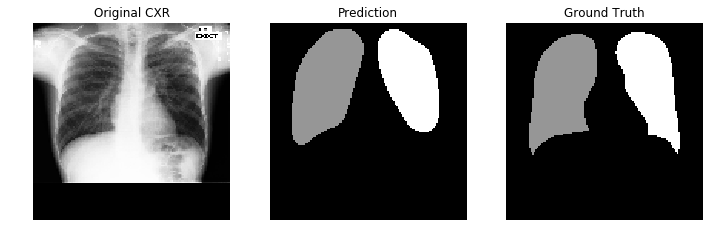

In [19]:
import keras
model = keras.models.load_model('unet_model.h5',custom_objects={'dice_coef':dice_coef,'dice_error':dice_error})

image, mask = next(val_generator)

segmentation = model.predict(image).argmax(axis=3)
mask = mask.argmax(axis=3)


for img, sgm, msk in zip(image, segmentation, mask):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1, 3, 1)
    ax.set_title('Original CXR')
    ax.imshow(img[...,0], cmap=cm.Greys_r, interpolation='none')
    ax.axis('off')

    ax = plt.subplot(1, 3, 2)
    ax.set_title('Prediction')
    ax.imshow(sgm, cmap=cm.Greys_r, interpolation='none')
    ax.axis('off')

    ax = plt.subplot(1, 3, 3)
    ax.set_title('Ground Truth')
    ax.imshow(msk, cmap=cm.Greys_r, interpolation='none')
    ax.axis('off')
    